**Universidad de los Andes**<br>
Facultad de Ingeniería<br>
__Maestría en Inteligencia Artificial__

# Alcanzando los objetivos de desarrollo sostenible.

Autores: __Andrés Vega__ y __David Méndez Acuña__

### Introducción

In [38]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud

In [39]:
class Context:
    '''
    Clase que permite almacenar el contexto de ejecución de los pasos 
    del pipeline. Esta clase será particularmente útil en el último 
    paso del pipeline donde necesitaremoslos datos generados por todos 
    los pasos del pipeline para imprimir el detalle de los resultados.
    '''
    def __init__(self) -> None:
        pass

    def log(message=None):
        '''
        Imprime el mensaje que entra por parámetro acompañado de la hora 
        actual. Este método será util para la trazabilidad de la ejecución
        del pipeline.  
        '''
        now = datetime.now()
        print(f'[INFO] {now.strftime("%H:%M:%S")} — {message}')

In [40]:
class FileLoader(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de cargar el archivo con los datos de  
    entrenamiento a partir de un archivo. En este paso se recibe la ruta del 
    archivo y se retorna un data frame con los datos organizados de manera tabular. 
    '''
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe la ruta de un archivo en el parámetro X y retorna un data frame
        con los datos organizados de manera tabular. 
        
        Parámetros relevantes
        ------------------------
        X : str
            La ruta del archivo que contiene los datos de entrenamiento. 

        Retornos
        ------------------------
        data_raw : pandas.DataFrame
            Los datos de entrenamiento organizados de manera tabular en un data frame. 

        '''
        Context.log(message='PASO 1: Cargar los datos de entrenamiento | Inicio de la ejecución')
        data_raw = pd.read_excel('./data/textos.xlsx')
        self.context.data_raw = data_raw
        Context.log(message='PASO 1: Cargar los datos de entrenamiento | Fin de la ejecución')
        return data_raw


In [41]:
class BagOfWords(BaseEstimator, TransformerMixin) :
    '''
    Este paseo del pipeline se encarga de transformar los datos de entrenamiento
    en una representación vectorial conforme a una bolsa de palabras. 

    '''
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe los datos de entrenamiento en una representación tabular y los retorna
        en forma de bolsa de palabras. 
        
        Parámetros relevantes
        ------------------------
        X : pandas.DataFrame
            Los datos de entrenamiento organizados de manera tabular en un data frame. 

         Retornos
        ------------------------
        bow : ...
            ...
        '''
        Context.log(message='PASO 2: Generar bolsa de palabras | Inicio de la ejecución')

        # Separamos los datos de las etiquetas y dividimos los datos en dos conjuntos, 
        # el primero para el entrenamiento y el segundo para las pruebas. 
        x_train = X["textos"]
        y_train = X["ODS"]

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=42, train_size=0.8)
        self.context.x_train = x_train
        self.context.y_train = y_train
        self.context.x_test = x_test
        self.context.y_test = y_test

        # Tokenización de los datos de entrenamiento 
        tokenized = x_train.apply(lambda x: word_tokenize(x))
        self.context.tokenized = tokenized

        tokenizer = RegexpTokenizer(r'\w+')
        tokenized_no_punct = x_train.apply(lambda x: tokenizer.tokenize(x))
        self.context.tokenized_no_punct = tokenized_no_punct

        # Removemos las palabras vacías
        nltk_stopwords = stopwords.words("spanish")
        no_stopwords = tokenized_no_punct.apply(lambda x: [token for token in x if token not in nltk_stopwords])
        self.context.no_stopwords = no_stopwords

        stemmer = PorterStemmer()
        stemmed = no_stopwords.apply(lambda x: [stemmer.stem(token) for token in x])
        processed = stemmed.apply(lambda x: ' '.join(x))
        self.context.processed = processed

        # Construimos la bolsa de palabras
        vectorizer = CountVectorizer()
        bow = vectorizer.fit_transform(processed)
        self.context.bow = bow

        Context.log(message='PASO 2: Generar bolsa de palabras | Fin de la ejecución')

        return bow

In [42]:
class PretryPrinter(BaseEstimator, TransformerMixin) :
     
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :

        wc_text = ' '.join(word for text in self.context.no_stopwords for word in text)

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color ='white',
            min_font_size=10,
            max_font_size=110
        ).generate(wc_text)
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
        
        return self
    
    def transform(self, X, y=None) :
         pass

[INFO] 23:19:34 — PASO 1: Cargar los datos de entrenamiento | Inicio de la ejecución
[INFO] 23:19:34 — PASO 1: Cargar los datos de entrenamiento | Fin de la ejecución
[INFO] 23:19:34 — PASO 2: Generar bolsa de palabras | Inicio de la ejecución
[INFO] 23:19:41 — PASO 2: Generar bolsa de palabras | Fin de la ejecución


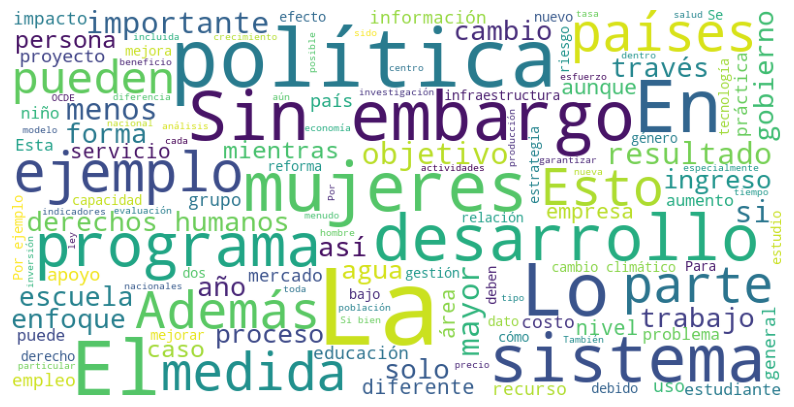

Pipeline(steps=[('loader',
                 FileLoader(context=<__main__.Context object at 0x2abd2ef10>)),
                ('bow',
                 BagOfWords(context=<__main__.Context object at 0x2abd2ef10>)),
                ('dimred', TruncatedSVD(n_components=100)),
                ('prettyPrinter',
                 PretryPrinter(context=<__main__.Context object at 0x2abd2ef10>))])

In [44]:
context = Context()

tsvd = TruncatedSVD(n_components=100)
logreg = LogisticRegression(max_iter=500)

steps = [
    ("loader", FileLoader(context)),
    ("bow", BagOfWords(context)),
    ("dimred", tsvd),
    #("model", logreg)
    ("prettyPrinter", PretryPrinter(context))
]
pipeline = Pipeline(steps)
pipeline.fit('./data/textos.xlsx')